<a href="https://colab.research.google.com/github/albaqawih/LLM-projects/blob/main/Mona_Day_2_Week_4_Entreprise_RAG_BigQuery_Palm_Redis_Semantic_Cache.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

\

# LLM Reference Architecture using Redis & Google Cloud Platform

This notebook serves as a getting started guide for working with LLMs on Google Cloud Platform with Redis Enterprise.

## Intro
Google's Vertex AI has expanded its capabilities by introducing [Generative AI](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview). This advanced technology comes with a specialized [in-console studio experience](https://cloud.google.com/vertex-ai/docs/generative-ai/start/quickstarts/quickstart), a [dedicated API](https://cloud.google.com/vertex-ai/docs/generative-ai/start/quickstarts/api-quickstart) and [Python SDK](https://cloud.google.com/vertex-ai/docs/python-sdk/use-vertex-ai-python-sdk) designed for deploying and managing instances of Google's powerful PaLM language models (more sample code). With a distinct focus on text generation, summarization, chat completion, and embedding creation, PaLM models are reshaping the boundaries of natural language processing and machine learning.

Redis Enterprise offers robust vector database features, with an efficient API for vector index creation, management, distance metric selection, similarity search, and hybrid filtering. When coupled with its versatile data structures - including lists, hashes, JSON, and sets - Redis Enterprise shines as the optimal solution for crafting high-quality Large Language Model (LLM)-based applications. It embodies a streamlined architecture and exceptional performance, making it an instrumental tool for production environments.

![](https://github.com/RedisVentures/redis-google-llms/blob/main/assets/GCP_RE_GenAI.drawio.png?raw=true)

Below we will work through several design patterns with Vertex AI LLMs and Redis Enterprise that will ensure optimal production performance.

___
## Contents
- Setup
    1. Prerequisites
    2. Create BigQuery Table
    3. Generate Embeddings
        
        a. Embed Text Data

    4. Load Embeddings to Redis
    5. Create Index
- Build LLM Applications
- LLM Design Patterns
    1. Semantic Search
    2. Retrieval Augmented Generation (RAG)
    3. Caching
    4. Memory
- Cleanup

___

# Setup

## 1. Prerequisites
Before we begin, we must install some required libraries, authenticate with Google, create a Redis database, and initialize other required components.

### Install required libraries

In [1]:
!pip install redis "google-cloud-aiplatform==1.25.0" --upgrade --user

### You will need to restart your session before running code below to continue.

In [2]:
!pip install -U faiss-cpu sentence_transformers transformers
!pip3 install google-cloud-aiplatform&gt==1.25
!pip install datasets
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 64.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyar

### Using Free Redis Cloud account on GCP
You can also use Forever Free instance of Redis Cloud. To activate it:
- Head to https://redis.com/try-free/
- Register (using gmail-based registration is the easiest)
- Create New Subscription
- Use the following options:
    - Fixed plan, Gogle Cloud
    - New 30Mb Free database
- Create new RedisStack DB

If you are registering at Redis Cloud for the first time - the last few steps would be performed for you by default. Capture the host, port and default password of the new database. You can use these instead of default `localhost` based in the following code block.

### Connect to Redis server
Replace the connection params below with your own if you are connecting to an external Redis instance.

In [3]:
import os
import redis

# Redis connection params
REDIS_HOST = os.getenv("REDIS_HOST", "redis-19987.c329.us-east4-1.gce.redns.redis-cloud.com:19987") #"redis-12110.c82.us-east-1-2.ec2.cloud.redislabs.com"
REDIS_PORT = os.getenv("REDIS_PORT", "19987")      #12110
REDIS_PASSWORD = os.getenv("REDIS_PASSWORD", "Q2dOgGNCjwNgJuyQqlZRs7pD4dUrahZn")  #"pobhBJP7Psicp2gV0iqa2ZOc1WdXXXXX"

# Create Redis client
redis_client = redis.Redis(
  host='redis-19987.c329.us-east4-1.gce.redns.redis-cloud.com',
  port=19987,
  password='Q2dOgGNCjwNgJuyQqlZRs7pD4dUrahZn')

# Test connection
redis_client.ping()

True

### Flush the database
Clear the Redis database if neccesary.

In [4]:
# Clear Redis database (optional)
redis_client.flushdb()

True

### Authenticate to Google Cloud

In [5]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [6]:
from getpass import getpass

# input your GCP project ID and region for Vertex AI
PROJECT_ID = getpass("PROJECT_ID:") #Insert your GCP Project ID
REGION = input("REGION:") #You will want to use us-central1 to access Vertex AI capabilities

PROJECT_ID:··········
REGION:us-central1


### Initialize Vertex AI Components



In [7]:
import vertexai

vertexai.init(project=PROJECT_ID, location=REGION)

In [8]:
!gcloud config set billing/quota_project 'adroit-approach-433713-g3'

Updated property [billing/quota_project].


In [9]:
!gcloud config set project 'adroit-approach-433713-g3'

Updated property [core/project].


In [10]:
!gcloud auth application-default set-quota-project 'adroit-approach-433713-g3'

ERROR: (gcloud.auth.application-default.set-quota-project) Application default credentials have not been set up. Run $ gcloud auth application-default login to set it up first.


In [11]:
! gcloud services enable compute.googleapis.com aiplatform.googleapis.com storage.googleapis.com bigquery.googleapis.com --project {PROJECT_ID}

Operation "operations/acat.p2-570403462360-89a58918-931f-4f93-83db-308caa7a0f62" finished successfully.


## Test Vertex AI

In [12]:
from vertexai.preview.language_models import TextEmbeddingModel
model = TextEmbeddingModel.from_pretrained("textembedding-gecko")

embeddings = model.get_embeddings(["Best hotel near the Louvre in Paris?"])
for embedding in embeddings:
  vector = embedding.values
  print(vector)

[0.08003706485033035, -0.05474206060171127, -0.013070491142570972, -0.03741488233208656, 0.046668365597724915, -0.019002703949809074, 0.012898107059299946, 0.0423712395131588, -0.0062309810891747475, 0.07155019044876099, 0.073456309735775, -0.002788882004097104, 0.021404290571808815, -0.00408377917483449, 0.07401784509420395, -0.06697126477956772, 0.014972888864576817, -0.018896862864494324, 0.027627021074295044, 0.01451321691274643, -0.01241000834852457, -0.004232931416481733, -0.0025933918077498674, -0.01348058320581913, 0.016662009060382843, -0.06458153575658798, 0.015941893681883812, -0.07335665076971054, -0.020411621779203415, -0.004635955207049847, -0.09065669029951096, 0.06166557967662811, -0.07016818970441818, -0.022152187302708626, 0.04693632945418358, -0.05851996690034866, 0.024985093623399734, 0.06918647140264511, -0.027579717338085175, 0.05550466477870941, 0.033612024039030075, 0.0011415068292990327, -0.06803540885448456, -0.012917742133140564, 0.025311211124062538, -0.0045

## 2. Create BigQuery Table
The second step involves preparing the dataset for our LLM applications. We utilize a free (public) hacker news dataset from **Google BigQuery**.

*Leveraging BigQuery is a common pattern for building ML applications because of it's powerful query and analytics capabilities.*

We will start by creating our own big query table for the dataset. Additionally, if you have a different dataset to work with you can follow a similar pattern, or even load a CSV from a Google Cloud Storage bucket into BigQuery.

### Create source table
First step is to create a new table from the public datasource.

In [13]:
from datasets import load_dataset
import pandas as pd

# Load the new dataset from Hugging Face Datasets
dataset = load_dataset("traversaal-ai-hackathon/hotel_datasets")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/5997 [00:00<?, ? examples/s]

In [14]:
df=pd.DataFrame(dataset['train'])

In [120]:
df.head()

,hotel_name,hotel_description,review_title,review_text,rate,tripdate,hotel_url,hotel_image,price_range,rating_value,review_count,street_address,locality,country
0,Romance Istanbul Hotel,Romance Istanbul Hotel has 39 rooms.Every room...,"An exceptional boutique hotel, great value for...",None,NaN,February 2020,https://www.tripadvisor.com/Hotel_Review-g2939...,https://media-cdn.tripadvisor.com/media/photo-...,$ (Based on Average Nightly Rates for a Standa...,5.0,4023,Hudavendigar Cd. No:5 Sirkeci,Istanbul,Turkiye
1,Romance Istanbul Hotel,Romance Istanbul Hotel has 39 rooms.Every room...,You can’t get better than this.,None,NaN,March 2021,https://www.tripadvisor.com/Hotel_Review-g2939...,https://media-cdn.tripadvisor.com/media/photo-...,$ (Based on Average Nightly Rates for a Standa...,5.0,4023,Hudavendigar Cd. No:5 Sirkeci,Istanbul,Turkiye
2,Romance Istanbul Hotel,Romance Istanbul Hotel has 39 rooms.Every room...,Exceeds all expectations,None,NaN,March 2021,https://www.tripadvisor.com/Hotel_Review-g2939...,https://media-cdn.tripadvisor.com/media/photo-...,$ (Based on Average Nightly Rates for a Standa...,5.0,4023,Hudavendigar Cd. No:5 Sirkeci,Istanbul,Turkiye
3,Romance Istanbul Hotel,Romance Istanbul Hotel has 39 rooms.Every room...,"Great Location, Fantastic Accommodations",None,NaN,August 2021,https://www.tripadvisor.com/Hotel_Review-g2939...,https://media-cdn.tripadvisor.com/media/photo-...,$ (Based on Average Nightly Rates for a Standa...,5.0,4023,Hudavendigar Cd. No:5 Sirkeci,Istanbul,Turkiye
4,Romance Istanbul Hotel,Romance Istanbul Hotel has 39 rooms.Every room...,Perfection. It is all in the details.,None,NaN,June 2021,https://www.tripadvisor.com/Hotel_Review-g2939...,https://media-cdn.tripadvisor.com/media/photo-...,$ (Based on Average Nightly Rates for a Standa...,5.0,4023,Hudavendigar Cd. No:5 Sirkeci,Istanbul,Turkiye


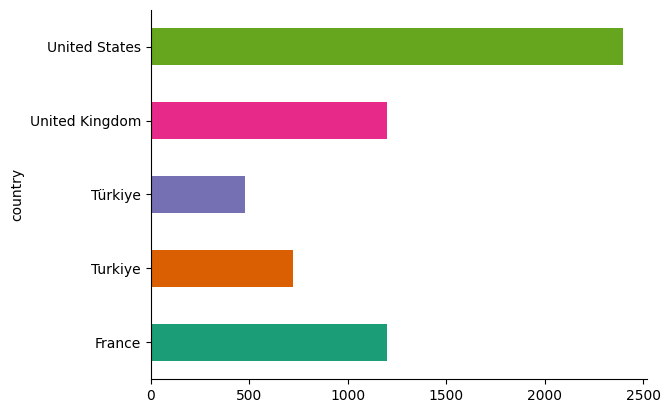

In [15]:
# @title country

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('country').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

#Adding an index

In [16]:
df["id"] = df.index + 1

In [17]:
from google.cloud import bigquery

# Create bigquery client
bq = bigquery.Client(project=PROJECT_ID)

TABLE_NAME = input("Input a Big Query TABLE_NAME:") #hotel_reviews
DATASET_ID = f"{PROJECT_ID}.google_redis_llms"

# Create dataset
dataset = bigquery.Dataset(DATASET_ID)
dataset.location = "US"
dataset = bq.create_dataset(dataset, timeout=30, exists_ok=True)

# Define table ID
TABLE_ID = f"{DATASET_ID}.{TABLE_NAME}"

Input a Big Query TABLE_NAME:hotel_reviews


In [18]:
!gcloud auth application-default login
!gcloud auth application-default set-quota-project 'adroit-approach-433713-g3'# YOUR TABLE-ID


You are running on a Google Compute Engine virtual machine.
The service credentials associated with this virtual machine
will automatically be used by Application Default
Credentials, so it is not necessary to use this command.

If you decide to proceed anyway, your user credentials may be visible
to others with access to this virtual machine. Are you sure you want
to authenticate with your personal account?

Do you want to continue (Y/n)?  y

Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fapplicationdefaultauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login&state=lZzYnLiyB0l8R7CHC8XSq51P8Ndw9b&prompt=consent&token_

In [19]:
from google.cloud import bigquery
from datetime import datetime, timedelta  # Import the necessary modules

# Create a BigQuery client
client = bigquery.Client()

# Get your table reference
table = client.get_table(TABLE_ID)

# Set table expiration (e.g., 30 days)
expiration_time = datetime.utcnow() + timedelta(days=30)
table.expires = expiration_time

# Update the table with the new expiration setting
client.update_table(table, ["expires"])


Table(TableReference(DatasetReference('adroit-approach-433713-g3', 'google_redis_llms'), 'hotel_reviews'))

In [20]:
# client = bigquery.Client()
job = bq.load_table_from_dataframe(
    df, TABLE_ID
)  # Make an API request.
job.result()

LoadJob<project=adroit-approach-433713-g3, location=US, id=9e5a7384-7be2-4486-9e97-ee3cdefe9c55>

In [21]:
table = bq.get_table(TABLE_ID)

In [22]:
table

Table(TableReference(DatasetReference('adroit-approach-433713-g3', 'google_redis_llms'), 'hotel_reviews'))

In [23]:
table.schema

[SchemaField('hotel_name', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('hotel_description', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('review_title', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('review_text', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('rate', 'FLOAT', 'NULLABLE', None, None, (), None),
 SchemaField('tripdate', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('hotel_url', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('hotel_image', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('price_range', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('rating_value', 'FLOAT', 'NULLABLE', None, None, (), None),
 SchemaField('review_count', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('street_address', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('locality', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('country', 'STRING', 'NULLABLE', None, None

Make sure to enable API key: https://cloud.google.com/bigquery/docs/explore-data-colab

## Load data from BigQuery - Hotel reviews.csv

In [25]:
%%bigquery results --project adroit-approach-433713-g3
SELECT * FROM `adroit-approach-433713-g3.google_redis_llms.hotel_reviews` # YOUR TABLE-ID

Query is running:   0%|          |

Downloading:   0%|          |

In [26]:
results

,hotel_name,hotel_description,review_title,review_text,rate,tripdate,hotel_url,hotel_image,price_range,rating_value,review_count,street_address,locality,country,id
0,Citadines Tour Eiffel Paris,None,No pride of ownership,If you’ve ever stayed at a hotel which owners ...,2.0,November 2023,https://www.tripadvisor.com/Hotel_Review-g1871...,https://media-cdn.tripadvisor.com/media/photo-...,$$ (Based on Average Nightly Rates for a Stand...,4.0,471,132 boulevard de Grenelle 15th Arr.,Paris,France,5598
1,Citadines Tour Eiffel Paris,None,Location Location!,"Citadines for is located in a great place, clo...",4.0,April 2023,https://www.tripadvisor.com/Hotel_Review-g1871...,https://media-cdn.tripadvisor.com/media/photo-...,$$ (Based on Average Nightly Rates for a Stand...,4.0,471,132 boulevard de Grenelle 15th Arr.,Paris,France,5599
2,Citadines Tour Eiffel Paris,None,Amazing stay!,We absolutely loved this hotel! The staff was ...,5.0,November 2023,https://www.tripadvisor.com/Hotel_Review-g1871...,https://media-cdn.tripadvisor.com/media/photo-...,$$ (Based on Average Nightly Rates for a Stand...,4.0,471,132 boulevard de Grenelle 15th Arr.,Paris,France,5600
3,Citadines Tour Eiffel Paris,None,Best Hotel in the area,This place was exactly what I needed for my lo...,5.0,June 2023,https://www.tripadvisor.com/Hotel_Review-g1871...,https://media-cdn.tripadvisor.com/media/photo-...,$$ (Based on Average Nightly Rates for a Stand...,4.0,471,132 boulevard de Grenelle 15th Arr.,Paris,France,5601
4,Citadines Tour Eiffel Paris,None,Magnificent city.,Dissapointed . Tower Eiffel was not as i excpe...,4.0,September 2023,https://www.tripadvisor.com/Hotel_Review-g1871...,https://media-cdn.tripadvisor.com/media/photo-...,$$ (Based on Average Nightly Rates for a Stand...,4.0,471,132 boulevard de Grenelle 15th Arr.,Paris,France,5602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35977,The Gate,Situated a few minutes’ walk from London’s Ald...,One night stay. Studio apartment,Friendly & welcoming staff. Modern & well main...,5.0,September 2023,https://www.tripadvisor.com/Hotel_Review-g1863...,https://media-cdn.tripadvisor.com/media/photo-...,$$ (Based on Average Nightly Rates for a Stand...,5.0,920,41 White Church Lane,London,United Kingdom,3356
35978,The Gate,Situated a few minutes’ walk from London’s Ald...,Fantastic!,Had to book a last minute room after missing o...,5.0,August 2023,https://www.tripadvisor.com/Hotel_Review-g1863...,https://media-cdn.tripadvisor.com/media/photo-...,$$ (Based on Average Nightly Rates for a Stand...,5.0,920,41 White Church Lane,London,United Kingdom,3357
35979,The Gate,Situated a few minutes’ walk from London’s Ald...,Great stay!,"We had a great time at the Gate Hotel, the fac...",5.0,September 2023,https://www.tripadvisor.com/Hotel_Review-g1863...,https://media-cdn.tripadvisor.com/media/photo-...,$$ (Based on Average Nightly Rates for a Stand...,5.0,920,41 White Church Lane,London,United Kingdom,3358
35980,The Gate,Situated a few minutes’ walk from London’s Ald...,Heartfelt Appreciation for Mohammad's Outstand...,The Gate London Hotel provides a memorable and...,5.0,September 2023,https://www.tripadvisor.com/Hotel_Review-g1863...,https://media-cdn.tripadvisor.com/media/photo-...,$$ (Based on Average Nightly Rates for a Stand...,5.0,920,41 White Church Lane,London,United Kingdom,3359


## 3. Generate Embeddings

### Create text embeddings with Vertex AI embedding model
Use the [Vertex AI API for text embeddings](https://cloud.google.com/vertex-ai/docs/generative-ai/embeddings/get-text-embeddings), developed by Google.

> Text embeddings are a dense vector representation of a piece of content such that, if two pieces of content are semantically similar, their respective embeddings are located near each other in the embedding vector space. This representation can be used to solve common NLP tasks, such as:
> - **Semantic search**: Search text ranked by semantic similarity.
> - **Recommendation**: Return items with text attributes similar to the given text.
> - **Classification**: Return the class of items whose text attributes are similar to the given text.
> - **Clustering**: Cluster items whose text attributes are similar to the given text.
> - **Outlier Detection**: Return items where text attributes are least related to the given text.

The `textembedding-gecko` model accepts a maximum of 3,072 input tokens (i.e. words) and outputs 768-dimensional vector embeddings.

### Define embedding helper function
We define a helper function, `embedding_model_with_backoff`, to create embeddings from a list of texts while making it resilient to [Vertex AI API quotas](https://cloud.google.com/vertex-ai/docs/quotas) via [exponential backoff](https://en.wikipedia.org/wiki/Exponential_backoff).

We also define a method to convert an array of floats to a byte string for efficient storage in Redis (later on).



In [27]:
vertexai.init()

In [134]:
!gcloud config set billing/quota_project 'adroit-approach-433713-g3'

Updated property [billing/quota_project].


In [135]:
!gcloud config get-value core/project


adroit-approach-433713-g3


In [136]:
!gcloud config set project 'adroit-approach-433713-g3'

Updated property [core/project].


In [28]:
!gcloud services enable aiplatform.googleapis.com
!gcloud services enable serviceusage.googleapis.com
!gcloud services enable cloudresourcemanager.googleapis.com


In [29]:
from typing import Generator, List, Any

from tenacity import retry, stop_after_attempt, wait_random_exponential
from vertexai.preview.language_models import TextEmbeddingModel

# Embedding model definition from VertexAI PaLM API
embedding_model = TextEmbeddingModel.from_pretrained("textembedding-gecko@003")
VECTOR_DIMENSIONS = 768
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(3))
def embed_text(text=[]):
    embeddings = embedding_model.get_embeddings(text)
    return [each.values for each in embeddings]

# Convert embeddings to bytes for Redis storage
def convert_embedding(emb: List[float]):
  return np.array(emb).astype(np.float32).tobytes()

### Embed text data
At the moment, our table in BigQuery (created above), contains records of the hacker news posts that we wish to embed and make available for LLMs.

In order to conserve RAM usage of this machine, we will iterate over batches of posts from BigQuery, create embeddings, and write them to Redis, which is being used as a [vector database](https://redis.com/solutions/use-cases/vector-database).

Below we define a few helper functions for processing a single row of data, writing batches to **Redis**, querying source data from **BigQuery**, and creating text embeddings with **Vertex AI**.

In [30]:
import pandas as pd
import numpy as np

QUERY_TEMPLATE = f"""
SELECT id,review_title, review_text, hotel_name
FROM `adroit-approach-433713-g3.google_redis_llms.hotel_reviews`
LIMIT {{limit}} OFFSET {{offset}};
"""

def query_bigquery_batches(
    max_rows: int,
    rows_per_batch: int,
    start_batch: int = 0
) -> Generator[pd.DataFrame, Any, None]:
    # Generate batches from a table in big query
    for offset in range(start_batch, max_rows, rows_per_batch):
        query = QUERY_TEMPLATE.format(limit=rows_per_batch, offset=offset)
        query_job = bq.query(query)
        rows = query_job.result()
        df = rows.to_dataframe()
        # Join title and text fields
        df["content"] = df.apply(lambda r: "Title: " + r.review_title + ". Content: " + r.review_text, axis=1)
        yield df


In [31]:
import math
from tqdm.auto import tqdm


# Redis key helper function
def redis_key(key_prefix: str, id: str) -> str:
  return f"{key_prefix}:{id}"

# Process a single dataset record
def process_record(record: dict) -> dict:
  return {
      'id': record['id'],
      'embedding': record['embedding'],
      'text': record['review_text'],
      'title': record['review_title']
  }

# Load batch of data into Redis as HASH objects
def load_redis_batch(
    redis_client: redis.Redis,
    dataset: list,
    key_prefix: str = "doc",
    id_column: str = "id",
):
    pipe = redis_client.pipeline()
    for i, record in enumerate(tqdm(dataset)):
        record = process_record(record)
        key = redis_key(key_prefix, record[id_column])
        pipe.hset(key, mapping=record)
    pipe.execute()

# Run the entire process
def create_embeddings_bigquery_redis(redis_client):
    # Create generator from BigQuery
    max_rows = 1000
    rows_per_batch = 100
    bq_content_query = query_bigquery_batches(max_rows, rows_per_batch)

    for batch in tqdm(bq_content_query):
      # Split batch into smaller chunks for embedding generation
      batch_splits = np.array_split(batch, math.ceil(rows_per_batch/5))
      # Create embeddings
      batch["embedding"] = [
          convert_embedding(embedding)
          for split in batch_splits
          for embedding in embed_text(split.content)
      ]
      # Write batch to Redis
      batch = batch.to_dict("records")
      load_redis_batch(redis_client, batch)


## 4. Load Embeddings
Now that we have a function to generate BigQuery batches, create text embeddings, and write batches to Redis, we can run the single function to process our entire dataset:

Enable: https://console.cloud.google.com/apis/library/aiplatform.googleapis.com?project=maven-advanced-llm

In [32]:
create_embeddings_bigquery_redis(redis_client)

0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/100 [00:00<?, ?it/s]

In [33]:
# Validate how many records are stored in Redis
redis_client.dbsize()

1000

## 5. Create Vector Index

Now that we have created embeddings that represent the text in our dataset and stored them in Redis, we will create a secondary index that enables efficient search over the embeddings. To learn more about the vector similarity features in Redis, [check out these docs](https://redis.io/docs/interact/search-and-query/search/vectors/) and [these Redis AI resources](https://github.com/RedisVentures/redis-ai-resources).

**Why do we need to enable search???**
Using Redis for vector similarity search allows us to retrieve chunks of text data that are **similar** or **relevant** to an input question or query. This will be extremely helpful for our sample generative ai / LLM application.

In [34]:
from redis.commands.search.field import (
    NumericField,
    TagField,
    TextField,
    VectorField,
)
from redis.commands.search.indexDefinition import IndexDefinition, IndexType
from redis.commands.search.query import Query


INDEX_NAME = "google:idx"
PREFIX = "doc:"
VECTOR_FIELD_NAME = "embedding"

# Store vectors in redis and create index
def create_redis_index(
    redis_client: redis.Redis,
    vector_field_name: str = VECTOR_FIELD_NAME,
    index_name: str = INDEX_NAME,
    prefix: list = [PREFIX],
    dim: int = VECTOR_DIMENSIONS
  ):

    # Construct index
    try:
        redis_client.ft(index_name).info()
        print("Existing index found. Dropping and recreating the index", flush=True)
        redis_client.ft(index_name).dropindex(delete_documents=False)
    except:
        print("Creating new index", flush=True)

    # Create new index
    redis_client.ft(index_name).create_index(
        (
            VectorField(
                vector_field_name, "FLAT",
                {
                    "TYPE": "FLOAT32",
                    "DIM": dim,
                    "DISTANCE_METRIC": "COSINE",
                }
            )
        ),
        definition=IndexDefinition(prefix=prefix, index_type=IndexType.HASH)
    )

In [35]:
# Create index
create_redis_index(redis_client)

Creating new index


In [36]:
# Inspect index attributes
redis_client.ft(INDEX_NAME).info()

{'index_name': 'google:idx',
 'index_options': [],
 'index_definition': [b'key_type',
  b'HASH',
  b'prefixes',
  [b'doc:'],
  b'default_score',
  b'1'],
 'attributes': [[b'identifier',
   b'embedding',
   b'attribute',
   b'embedding',
   b'type',
   b'VECTOR',
   b'algorithm',
   b'FLAT',
   b'data_type',
   b'FLOAT32',
   b'dim',
   768,
   b'distance_metric',
   b'COSINE']],
 'num_docs': '1000',
 'max_doc_id': '1000',
 'num_terms': '0',
 'num_records': '1000',
 'inverted_sz_mb': '0',
 'vector_index_sz_mb': '3.0295867919921875',
 'total_inverted_index_blocks': '0',
 'offset_vectors_sz_mb': '0',
 'doc_table_size_mb': '0.0705718994140625',
 'sortable_values_size_mb': '0',
 'key_table_size_mb': '0.03100299835205078',
 'tag_overhead_sz_mb': '0',
 'text_overhead_sz_mb': '0',
 'total_index_memory_sz_mb': '0.10157489776611328',
 'geoshapes_sz_mb': '0',
 'records_per_doc_avg': '1',
 'bytes_per_record_avg': '0',
 'offsets_per_term_avg': '0',
 'offset_bits_per_record_avg': 'nan',
 'hash_index

In [38]:
# Retreive single HASH from Redis
key = redis_client.keys()[1]
redis_client.hgetall(key)

{b'text': b'We have stayed here on every Paris visit for the last decade or more. Previously, we had found the staff charming and very friendly. This time they were merely efficient. When we rent in an apartment hotel, which this pretends to be, we plan to do some of our own cooking, especially in France where there is so much good food available and in this case a market steps from the front door on Wednesdays and Sundays. These units are so poorly equipped that this is virtually impossible. Even then, there were shortages of what was supposed to be available. One teaspoon for two people? One coffee mug for two people? Two small glasses, which is less than you usually get in an ordinary hotel room. The studio rooms are adequate and well insulated for sound, even those at the front a few',
 b'id': b'5620',
 b'title': b'Great place to stay, but not to cook',
 b'embedding': b',N[=\x9dz\xa5\xbc=\n`\xbdu\xad7\xbd\x06\x8a\x1f=\xb7\xe2\x07:[\xa9E<\x97\xe5\x19\xbc\xc5p4=\xfa\x1e\r=\xd8N\x04=\

At this point, our **Redis** datastore is completely loaded with a subset of data from **BigQuery** including text embeddings created with **Vertex AI** PaLM APIs.

# Build LLM applications
With Redis fully loaded as a vector database and powerful PaLM APIs at our disposal, we can build a number of AI applications on this stack. Below we will briefly describe each of these applications and use cases

- **Document Retrieval** - search through documents to return only the most relevant to a given query.
- **Product Recommendations** - recommend products with similar attributes and descriptions to a product the shopper likes.
- **Chatbots** - provide a conversational interface for information retrieval or customer service.
- **Text Summarization & Generation** - Generate new copy from sources of relevant information to accelerate team output.
- **Fraud/Anomaly Detection** - identify anomalous and potentially fraudulent events, transactions, or items based on attribute similarity of other known entities.

# LLM Design Patterns

In order to build these kinds of apps, below we highlight 4 technical design patterns and techniques where Redis Enterprise comes in handy to boost LLM performance:

- **Semantic Search**
- **Retrieval Augmented Generation (RAG)**
- **Caching**
- **Memory**

Leveraging some combination of these patterns is recommended best practice, derived from enterprise use cases and open source users all over the world.

### Simple Semantic Search


**Semantic Search**, in the context of Large Language Models (LLMs), is a sophisticated search technique that goes beyond *literal* keyword matching to understand the contextual meaning and intent behind user queries. Leveraging the power of Google's Vertex AI platform and Redis' vector database capabilities, semantic search can map and extract deep-level knowledge from vast text datasets, including nuanced relationships and hidden patterns.

This allows applications to return search results that are contextually relevant, enhancing user experience by offering meaningful responses, even to complex or ambiguous search terms. Thus, semantic search not only boosts the accuracy and relevancy of search results but also empowers applications to interact with users in a more human-like, intuitive manner.

The general process of semantic search includes 3 steps:
1. Create query vector
2. Perform vector search
3. Review and return results

In [39]:
# 1. Create query vector
query = "What is the best hotel close to the Louvre?"
query_vector = embed_text([query])[0]

# Our query has been converted to a list of floats (this is a truncated view)
query_vector[:10]

[0.08164466172456741,
 -0.05301200598478317,
 -0.01196212973445654,
 -0.05362908914685249,
 0.0456140898168087,
 -0.020608795806765556,
 0.003969392739236355,
 0.038530223071575165,
 4.5475069782696664e-05,
 0.06444840133190155]

In [40]:
# Helper method to perform KNN similarity search in Redis
def similarity_search(query: str, k: int, return_fields: tuple, index_name: str = INDEX_NAME) -> list:
    # create embedding from query text
    query_vector = embed_text([query])[0]
    # create redis query object
    redis_query = (
        Query(f"*=>[KNN {k} @{VECTOR_FIELD_NAME} $embedding AS score]")
            .sort_by("score")
            .return_fields(*return_fields)
            .paging(0, k)
            .dialect(2)
    )
    # execute the search
    results = redis_client.ft(index_name).search(
        redis_query, query_params={"embedding": convert_embedding(query_vector)}
    )
    return pd.DataFrame([t.__dict__ for t in results.docs ]).drop(columns=["payload"])


In [41]:
# 2. Perform vector similarity search with given query
results = similarity_search(query, k=5, return_fields=("score", "title", "text"))

In [42]:
# 3. Review and return the results
display(results)

,id,score,title,text
0,doc:4923,0.165503203869,Wonderful hotel near the Louvre,We stayed at the Maison Favart for three days....
1,doc:4810,0.17958265543,5 stars,Super helpful staff. Nice lobby. Super helpful...
2,doc:4940,0.187327742577,Weekend in Paris,Great location - peaceful and very central - o...
3,doc:4926,0.190664052963,Fantastic location,We stayed for a short break for 3 nights . Fan...
4,doc:5498,0.191933095455,Great location near The Louvre,"Upon arrival, the staff at the hotel were very..."


Results above indicate that our search for recommended operating systems for software devs yielded some posts from Hacker News that might be helpful in answering this question.

**Interested in tuning the search results?**
- Try using a different [Distance Metric](https://redis.io/docs/interact/search-and-query/search/vectors/#creation-attributes-per-algorithm)
- Try using a different [Index Type](https://redis.io/docs/interact/search-and-query/search/vectors/#flat)

### Retrieval Augmented Generation (RAG)

**Retrieval Augmented Generation** (RAG), within the scope of Large Language Models (LLMs), is a technique that combines the knowledge of domain-specific data and generative models to enhance the production of contextually-rich question responses. In essence, *RAG* functions by retrieving relevant information from a knowledge base of documents or data before proceeding to generate a response. This allows generalized foundation models to gain access to these datasources at runtime, and is NOT the same thing as fine-tuning.

RAG exploits the strengths of Redis as a low-latency vector database for efficient retrieval operations and Google's Vertex AI to generate a coherent text response. In LLM applications, RAG enables a deeper comprehension of context, returning highly nuanced responses, even to intricate queries. This pattern enhances the interactive capability of applications, delivering more precise and informative responses, thereby significantly enriching the user experience.


In order to build a RAG pipeline for question answering, we need to use Vertex PaLM API for text generation (`text-bison@001`).

In [43]:
from vertexai.preview.language_models import TextGenerationModel

# Define generation model
generation_model = TextGenerationModel.from_pretrained("text-bison@001")

response = generation_model.predict(prompt="What is a large language model?")

print("Example response:\n", response.text)


Example response:
 A large language model (LLM) is a type of artificial intelligence (AI) model that can understand and generate human language. LLMs are trained on massive datasets of text and code, and they can learn to perform a wide variety of tasks, such as translating languages, writing different kinds of creative content, and answering your questions in an informative way.

LLMs are still under development, but they have the potential to revolutionize many industries. For example, LLMs could be used to create more accurate and personalized customer service experiences, to help doctors diagnose and treat diseases, and to even write entire books and movies.




In order to be able to answer questions **while referencing domain-specific sources** (like our sample hackernews dataset), we must build a RAG pipeline:

1. First perform **Semantic Search** with the user query on the knowledge base (stored in Redis) to find relevant sources that will help the language model answer and respond intelligently.

2. The sources (called context) are "stuffed" into the prompt (input).

3. Lastly, the full prompt is passed on to the language model for text generation.

In [44]:
def create_prompt(prompt_template: str, **kwargs) -> str:
  return prompt_template.format(**kwargs)

def rag(query: str, prompt: str, verbose: bool = True) -> str:
    """
    Simple pipeline for performing retrieval augmented generation with
    Google Vertex PaLM API and Redis Enterprise.
    """
    # Perform a vector similarity search in Redis
    if verbose:
        print("Pulling relevant data sources from Redis", flush=True)
    relevant_sources = similarity_search(query, k=3, return_fields=("text",))
    if verbose:
        print("Relevant sources found!", flush=True)
    # Combine the relevant sources and inject into the prompt
    sources_text = "-" + "\n-".join([source for source in relevant_sources.text.values])
    full_prompt = create_prompt(
        prompt_template=prompt,
        sources=sources_text,
        query=query
      )
    if verbose:
        print("\nFull prompt:\n\n", full_prompt, flush=True)
    # Perform text generation to get a response from PaLM API
    response = generation_model.predict(prompt=full_prompt)
    return response.text



Below is an example prompt template. Feel free to edit and tweak the initial sentence that sets the context for the language model to perform the action we are anticipating. The process of tuning and iterating on prompt design is widely refered to as "*prompt engineering*".

In [45]:
PROMPT = """You are a helpful virtual technology and IT assistant. Use the transcript context and sources to help answer the user question. Don't blindly make things up.

SOURCES:
{sources}

QUESTION:
{query}?

ANSWER:"""



In [46]:
query = "What is the best hotel close to the Louvre?"
response = rag(query=query, prompt=PROMPT)
print(response)

Pulling relevant data sources from Redis
Relevant sources found!

Full prompt:

 You are a helpful virtual technology and IT assistant. Use the transcript context and sources to help answer the user question. Don't blindly make things up.

SOURCES:
-We stayed at the Maison Favart for three days. First of all, the hotel is close to the Louvre, so it is perfect for a visit there. The rooms and lobby of the hotel are very nicely decorated. The staff were very friendly and catered for all our needs. Would definitely come back next time!
-Super helpful staff. Nice lobby. Super helpful staff. Would definitely stay here again. Super close to the louvre as well as a short walk to the arc de triomphe. Coffee available 24/7 in the lobby. Snacks, water, soda available in the afternoons.
-Great location - peaceful and very central - opposite the Opera House.  Fifteen minutes walk down to the Louvre and many good restaurants close by.  Very comfortable beds and pretty breakfast room.  Front of Hous

In [47]:
query = "What are some amazing hotels near Big ben?"
response = rag(query=query, prompt=PROMPT)
print(response)

Pulling relevant data sources from Redis
Relevant sources found!

Full prompt:

 You are a helpful virtual technology and IT assistant. Use the transcript context and sources to help answer the user question. Don't blindly make things up.

SOURCES:
-We had a fantastic stay! This was our second time in this wonderful hotel where everything has this extra something. From the beds , the food and the friendly people at work. We really enjoyed ourselves! 
-Excellent hotel, beds were so comfortable and rooms were clean and of a good size. My daughter and I also loved the free hot chocolate which we enjoyed in the outdoor patio area every evening. Very quiet peaceful hotel, and would highly recommend.
-We had a really wonderful stay the Grand Hotel.  The staff was always friendly and they went out of their way to make our experience lovely and memorable.  Our room was spacious and well-appointed.  The hotel was perfectly located for all the sights and easy access to the metro.  I would defini

Clearly this example dataset (hotel reviews) is not the only example we could work with. This is also only utilizing a subset (1000 records) of the actual data for teaching purposes.

However, this example demonstrates how you can combine external sources of data and LLMs to surface more useful information.

### LLM Caching

**LLM Caching** is an advanced strategy used to optimize the performance of Large Language Model (LLM) applications. Utilizing the ultra-fast, in-memory data store of Redis, LLM Caching enables the storage and quick retrieval of pre-computed responses generated by Google's Vertex AI (PaLM). This means the computationally expensive process of response generation, especially for repetitive queries, is significantly reduced, resulting in faster response times and efficient resource utilization. This pairing of Google's powerful generative AI capabilities with Redis' high-performance caching system thus facilitates a more scalable and performant architecture for LLM applications, improving overall user experience and application reliability.

There are primarily two modes of caching for LLMs:
- Standard Caching
- Semantic Caching

## Semantic Caching
Semantic caching allows the model to pull from cache if the query is similar to a past query to speed up results. In standard caching the query must be the exact same question but with semantic caching we will look at the similarity of the text and if it is within a certain threshold we pull the answer from memory. Our semantic cache writes and retrieves data on GCP Cloud SQL.


### Connecting to Google Cloud SQL using the Python Connector

#### 🔐 Authenticate to Google Cloud within Colab
Authenticate to Google Cloud as the IAM user logged into this notebook in order to access your Google Cloud Project.

In [48]:
#Authenticate
from google.colab import auth

auth.authenticate_user()

#### 🔗 Connect Your Google Cloud Project
Time to connect your Google Cloud Project to this notebook so that you can leverage Google Cloud from within Colab. 🏅 😀

In [49]:
#@markdown Please fill in the value below with your GCP project ID and then run the cell.

# Please fill in these values.
project_id = "adroit-approach-433713-g3" #@param {type:"string"}

# Quick input validations.
assert project_id, "⚠️ Please provide a Google Cloud project ID"

# Configure gcloud.
!gcloud config set project {project_id}

Updated property [core/project].


### ☁ Configure Your Google Cloud Project
Configure the following in your Google Cloud Project.

1. IAM principal (user, service account, etc.) with the
[Cloud SQL Client][client-role] role.

> 🚨 The user logged into this notebook will be used as the IAM principal and will be granted the Cloud SQL Client role.

[client-role]: https://cloud.google.com/sql/docs/mysql/roles-and-permissions

In [50]:
# grant Cloud SQL Client role to authenticated user
current_user = !gcloud auth list --filter=status:ACTIVE --format="value(account)"

!gcloud projects add-iam-policy-binding adroit-approach-433713-g3 \
  --member=user:{current_user[0]} \
  --role="roles/cloudsql.client"

Updated IAM policy for project [adroit-approach-433713-g3].
bindings:
- members:
  - user:Albaqawih@gmail.com
  role: roles/cloudsql.client
- members:
  - serviceAccount:service-570403462360@compute-system.iam.gserviceaccount.com
  role: roles/compute.serviceAgent
- members:
  - serviceAccount:570403462360-compute@developer.gserviceaccount.com
  - serviceAccount:570403462360@cloudservices.gserviceaccount.com
  role: roles/editor
- members:
  - user:Albaqawih@gmail.com
  role: roles/owner
etag: BwYgrUvsrqw=
version: 1


2. Enable the [Cloud SQL Admin API][admin-api] within your project.

[admin-api]: https://console.cloud.google.com/apis/api/sqladmin.googleapis.com

In [51]:
# enable Cloud SQL Admin API
!gcloud services enable sqladmin.googleapis.com

####💽 **Create a SQL Server Instance**
Running the below cell will verify the existence of a Cloud SQL instance or create a new one if one does not exist.

> ⏳ - Creating a Cloud SQL instance may take a few minutes.

In [52]:
#@markdown Please fill in the both the Google Cloud region and name of your Cloud SQL instance. Once filled in, run the cell.

# Please fill in these values.
region = "us-central1" #@param {type:"string"}
instance_name = "adroit-approach-433713-g3" #@param {type:"string"}

# Quick input validations.
assert region, "⚠️ Please provide a Google Cloud region"
assert instance_name, "⚠️ Please provide the name of your instance"

# check if Cloud SQL instance exists in the provided region
database_version = !gcloud sql instances describe {instance_name} --format="value(databaseVersion)"
if database_version[0].startswith("SQLSERVER"):
  print("Found existing SQL Server Cloud SQL Instance!")
  sqlserver_pass = ""
else:
  print("Creating new Cloud SQL instance...")
  sqlserver_pass = input("Please provide a password to be used for '' database user: ")
  !gcloud sql instances create {instance_name} --database-version=SQLSERVER_2019_STANDARD \
    --region={region} --cpu=1 --memory=4GB --root-password={sqlserver_pass}

Creating new Cloud SQL instance...
Please provide a password to be used for '' database user: albaqawih
Created [https://sqladmin.googleapis.com/sql/v1beta4/projects/adroit-approach-433713-g3/instances/adroit-approach-433713-g3].
NAME                       DATABASE_VERSION         LOCATION       TIER              PRIMARY_ADDRESS  PRIVATE_ADDRESS  STATUS
adroit-approach-433713-g3  SQLSERVER_2019_STANDARD  us-central1-c  db-custom-1-4096  34.71.110.96     -                RUNNABLE


### 🥪 Create a Hotel Reviews Database
A `semantic-cache-db` database will be used in later steps when connecting to and querying a Cloud SQL database.

To create a `semantic-cache-db` database within your Cloud SQL instance run the below command:

In [53]:
!gcloud sql databases create semantic-cache-db --instance={instance_name}

Created database [semantic-cache-db].
instance: adroit-approach-433713-g3
name: semantic-cache-db
project: adroit-approach-433713-g3


#### 🐍 Python Connector Usage
Let's now connect to Cloud SQL using the Python Connector! 🚀 ⭐ 🐍

#### 💻 **Install Code Dependencies**
It is recommended to use the Connector alongside a library that can create connection pools, such as [SQLAlchemy](https://www.sqlalchemy.org/).
This will allow for connections to remain open and be reused, reducing connection overhead and the number of connections needed

Let's `pip install` the [Cloud SQL Python Connector](https://github.com/GoogleCloudPlatform/cloud-sql-python-connector) as well as [SQLAlchemy](https://www.sqlalchemy.org/), using the below command.

In [54]:
# install dependencies
import sys
!{sys.executable} -m pip install cloud-sql-python-connector["pytds"] SQLAlchemy==2.0.7 sqlalchemy-pytds==0.3.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.6 MB/s eta 0:00:00
  Created wheel for python-tds: filename=python_tds-1.15.0-py3-none-any.whl size=85032 sha256=3b352e28b091c9154f9c147bca854f9953baa7bd68729964d3ae0d86efafcf49
  Stored in directory: /root/.cache/pip/wheels/fb/18/28/9255c9a9f47d6fc0ccc229eef066356b9d0a6b07aec4f50114
Successfully built python-tds
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.32
    Uninstalling SQLAlchemy-2.0.32:
      Successfully uninstalled SQLAlchemy-2.0.32
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.27.0
    Uninstalling google-auth-2.27.0:
      Successfully uninstalled google-auth-2.27.0
E

#### 🗄 **Connect to a SQL Server Instance**
We are now ready to connect to a SQL Server instance using the Cloud SQL Python Connector! 🐍 ⭐ ☁


Let's set some parameters that are needed to connect properly to a Cloud SQL instance:
*   `INSTANCE_CONNECTION_NAME` : The connection name to your Cloud SQL Instance, takes the form `PROJECT_ID:REGION:INSTANCE_NAME`.
*   `DB_USER` : The user that the connector will use to connect to the database.
*   `DB_PASS` : The password of the DB_USER.
*   `DB_NAME` : The name of the database on the Cloud SQL instance to connect to.

In [55]:
# initialize parameters
INSTANCE_CONNECTION_NAME = f"{project_id}:{region}:{instance_name}" # i.e demo-project:us-central1:demo-instance
print(f"Your instance connection name is: {INSTANCE_CONNECTION_NAME}")
DB_USER = "sqlserver"
# verify password for 'sqlserver' user is set (already set for those that created a Cloud SQL instance within this notebook)
try:
  assert sqlserver_pass
except:
  sqlserver_pass = input("Please provide the password for your 'sqlserver' database user: ")
DB_PASS = sqlserver_pass
DB_NAME = "semantic-cache-db"

Your instance connection name is: adroit-approach-433713-g3:us-central1:adroit-approach-433713-g3


### ✅ **Basic Usage**
To connect to Cloud SQL using the connector, inititalize a `Connector` object and call its `connect` method with the proper input parameters.

The `connect` method takes in the parameters we previously defined, as well as a few additional parameters such as:
*   `driver`: The name of the database driver to connect with.
*   `ip_type` (optional): The IP type (public or private)  used to connect. IP types can be either `IPTypes.PUBLIC` or `IPTypes.PRIVATE`. ([Example](#scrollTo=yjAPpIDdRfu2))
*   `enable_iam_auth`: (optional) Boolean enabling IAM based authentication. (Postgres and MySQL only)

Let's show an example! 🤘 🙌

In [56]:
from google.cloud.sql.connector import Connector
import sqlalchemy
from sqlalchemy import Column, Float, Integer, String, Table

# initialize Connector object
connector = Connector()

# function to return the database (db) connection object
def getconn():
    conn = connector.connect(
        INSTANCE_CONNECTION_NAME,
        "pytds",
        user=DB_USER,
        password=DB_PASS,
        db=DB_NAME
    )
    return conn

# create connection pool with 'creator' argument to our connection object function
pool = sqlalchemy.create_engine(
    "mssql+pytds://",
    creator=getconn,
)

<ipython-input-56-600939a4548e>:20: SADeprecationWarning: The dbapi() classmethod on dialect classes has been renamed to import_dbapi().  Implement an import_dbapi() classmethod directly on class <class 'sqlalchemy_pytds.dialect.MSDialect_pytds'> to remove this warning; the old .dbapi() classmethod may be maintained for backwards compatibility.
  pool = sqlalchemy.create_engine(


#### Now that we have established a connection pool, let's write a query! 🎉 📝

##### Import Libraries for semantic cache and SQL connection

In [57]:
import faiss
import json
import numpy as np
from sentence_transformers import SentenceTransformer
import sqlalchemy
from sqlalchemy import Table, Column, Integer, String, MetaData, Float, select


##### Define semantic cache table schema

In [58]:
# Assuming 'pool' is your SQLAlchemy connection pool already configured for your database
metadata = MetaData()

# Define the semantic_cache table schema
semantic_cache_table = Table(
    "semantic_cache",
    metadata,
    Column("id", Integer, primary_key=True),
    Column("query", String),
    Column("embedding", String),
    Column("response", String),
)

##### Create semantic cache table

In [59]:
# Create a semantic cache table if it does not already exist
inspector = sqlalchemy.inspect(pool)
if not inspector.has_table("semantic_cache"):
    semantic_cache_table.create(pool)


##### Semantic Cache Class Overview

This defines a class named `SemanticCache` that provides an efficient way to cache and retrieve responses based on the semantic similarity of queries. It leverages a combination of FAISS (Facebook AI Similarity Search) for fast nearest neighbor search in high-dimensional spaces, and the Sentence Transformer library for generating semantic embeddings of text queries.

Functionalities:

- **Initialization (`__init__` method):** Initializes the semantic cache with a FAISS index for L2 distance (Euclidean distance), sets up a sentence encoder using the 'all-mpnet-base-v2' model, defines a threshold for determining semantic similarity based on Euclidean distance(.3), and initializes a connection pool for database operations. It also preloads any existing cache data into the FAISS index.

- **Loading cache (`load_cache` method):** Loads embeddings and other relevant data from a database table named `semantic_cache` into the FAISS index to allow for fast similarity searches. It ensures compatibility with different versions of SQLAlchemy by correctly accessing row data.

- **Adding to cache (`add_to_cache` method):** Encodes a given query into a semantic embedding, serializes the embedding for storage, and inserts the query, its embedding, and the corresponding response into the database. It also adds the embedding to the FAISS index for future similarity searches.

- **Retrieving responses (`get_response` method):** Encodes a query to find its semantic embedding, performs a similarity search in the FAISS index to find the nearest embedding, and retrieves the corresponding response from the database if the similarity is above a defined threshold(.3). This allows for fetching responses that are semantically similar to the input query, facilitating an efficient and intelligent caching mechanism.

This class is designed to improve the efficiency of responding to queries by caching responses based on their semantic content, reducing the need to recompute responses for semantically similar queries.


#### Decorators

In [60]:
def my_decorator(func):
    def wrapper():
        print("Something is happening before the function is called.")
        func()
        print("Something is happening after the function is called.")
    return wrapper

@my_decorator
def say_hello():
    print("Hello!")

In [61]:
say_hello()

Something is happening before the function is called.
Hello!
Something is happening after the function is called.


In [62]:
class SemanticCache:
    def __init__(self, pool):
        self.index = faiss.IndexFlatL2(768)  # Dimension of embeddings
        self.encoder = SentenceTransformer('all-mpnet-base-v2')
        self.euclidean_threshold = 0.3
        self.pool = pool
        self.load_cache()  # Load existing data into FAISS index

    def load_cache(self):
        with self.pool.connect() as db_conn:
            select_stmt = sqlalchemy.text("SELECT * FROM semantic_cache")
            results = db_conn.execute(select_stmt).fetchall()
            for row in results:
                # Ensure correct access to the row depending on the SQLAlchemy version
                embedding = np.array(json.loads(row['embedding'] if isinstance(row, dict) else row.embedding)).astype('float32')
                self.index.add(np.array([embedding]))


    def add_to_cache(self, query, response):
        query_embedding = self.encoder.encode([query]).astype('float32')[0]
        embedding_serialized = json.dumps(query_embedding.tolist())
        with self.pool.connect() as db_conn:
            insert_stmt = sqlalchemy.text(
                "INSERT INTO semantic_cache (query, embedding, response) VALUES (:query, :embedding, :response)"
            )
            db_conn.execute(insert_stmt, {"query": query, "embedding": embedding_serialized, "response": response})
            db_conn.commit()
        self.index.add(np.array([query_embedding]))  # Add to FAISS index

    def get_response(self, query):
        query_embedding = self.encoder.encode([query]).astype('float32')[0]
        D, I = self.index.search(np.array([query_embedding]), 1)
        if D[0][0] < self.euclidean_threshold:
            # Convert the ID to int explicitly, though it should already be an integer
            # This is more about ensuring the value is in a form that pytds can handle without confusion
            id_value = int(I[0][0] + 1)
            with self.pool.connect() as db_conn:
                # Use a parameterized query with explicit casting if necessary
                stmt = select(semantic_cache_table.c.response).where(semantic_cache_table.c.id == id_value)
                result = db_conn.execute(stmt).fetchone()
                if result:
                    return result[0]  # Accessing the response directly
        return None




#### Initialize the semantic cache with the SQLAlchemy engine


In [63]:
semantic_cache = SemanticCache(pool)

def semantic_llmcache(llm_callable):
    def wrapper(query: str):
        print("Checking semantic cache...")
        cached_response = semantic_cache.get_response(query)
        if cached_response:
            print("Found response in semantic cache.")
            return cached_response
        else:
            print("No response found in semantic cache, calling external function...")
            response = llm_callable(query)
            semantic_cache.add_to_cache(query, response)
            return response
    return wrapper



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [64]:
# Example usage
@semantic_llmcache
def ask_palm_semantic(query: str):
    # Explicitly calling RAG function here
    response = rag(query, PROMPT, verbose=True)
    return response

#### Performance

In [65]:
%%time
#Ask the question for the first time and clock the Wall time
ask_palm_semantic("What are some amazing hotels near Big Ben?")

Checking semantic cache...
No response found in semantic cache, calling external function...
Pulling relevant data sources from Redis
Relevant sources found!

Full prompt:

 You are a helpful virtual technology and IT assistant. Use the transcript context and sources to help answer the user question. Don't blindly make things up.

SOURCES:
-Fabulous location. Rooms have everything you need. Staff are excellent. An absolute delightful hotel in every way. Near many excellent restaurants and very near metro stations. I cannot recommend this hotel enough.
-Fab value hotel - great location, great service and the room was lovely! Spotless, Modern and a big comfy bed, what more can you ask for? Lovely bathroom too and a powerful, hot, shower   Lots of restaurants nearby and right across the road from the metro. In comparison to many of the surrounding hotels, in terms of value for money, this one wins hands down! 
-We had a really wonderful stay the Grand Hotel.  The staff was always friendly

'The Grand Hotel is a great option for those looking for a hotel near Big Ben. The hotel is located just a short walk from the iconic landmark, and offers a variety of amenities, including a fitness center, a spa, and a restaurant. The rooms are spacious and well-appointed, and the staff is friendly and helpful.'

Now if we ask the same question-but phrased differently -- we get the same response in near real-time.

In [66]:
%%time
#Ask the question for the first time and clock the Wall time-note how much faster it runs!
ask_palm_semantic("What are some amazing hotels around Big Ben?")

Checking semantic cache...
Found response in semantic cache.
CPU times: user 22.2 ms, sys: 0 ns, total: 22.2 ms
Wall time: 487 ms


'The Grand Hotel is a great option for those looking for a hotel near Big Ben. The hotel is located just a short walk from the iconic landmark, and offers a variety of amenities, including a fitness center, a spa, and a restaurant. The rooms are spacious and well-appointed, and the staff is friendly and helpful.'

With the semantic cache the speed went from 2.46 seconds to .0356 seconds. It ran 70X faster than the original query!

### Memory

Giving your application access to "memory" for chat history is a common technique to improve the models ability to reason through recent or past conversations, gain context from previous answers, and thus provide a more accurate and acceptable response.

Below we setup simple helper functions to persist and load conversation history in a Redis List data structure.

In [67]:
import json

def add_message(prompt: str, response: str):
    msg = {
        "prompt": prompt,
        "response": response
    }
    redis_client.lpush("chat-history", json.dumps(msg))

def get_messages(k: int = 5):
    return [json.loads(msg) for msg in redis_client.lrange("chat-history", 0, k)]

In [68]:
query = "Do you have any advice for getting started in the tech field as a software dev?"
response = rag(query, PROMPT, verbose=False)

print(response)

add_message(query, response)

There are a few things you can do to get started in the tech field as a software developer. First, you need to have a strong foundation in computer science. This includes knowledge of data structures, algorithms, and operating systems. You can learn these concepts by taking courses at a university or online. Second, you need to have experience developing software. You can get this experience by working on personal projects or by contributing to open source projects. Third, you need to be able to demonstrate your skills to potential employers. This can be done by creating a portfolio of your work or by taking part in coding competitions.


In [69]:
query = "What if I am still in college, any tips there?"
response = rag(query, PROMPT, verbose=False)

print(response)

add_message(query, response)

There are a few things you can do to save money on your trip to Paris if you are still in college. First, consider staying in a hostel. Hostels are typically much cheaper than hotels, and they can be a great way to meet other travelers. Second, look for student discounts on attractions and activities. Many museums and other attractions offer discounts to students, so be sure to ask when you purchase your tickets. Finally, consider cooking your own meals instead of eating out. This can save you a lot of money, especially if you are traveling with a group of friends.


In [70]:
get_messages()

[{'prompt': 'What if I am still in college, any tips there?',
  'response': 'There are a few things you can do to save money on your trip to Paris if you are still in college. First, consider staying in a hostel. Hostels are typically much cheaper than hotels, and they can be a great way to meet other travelers. Second, look for student discounts on attractions and activities. Many museums and other attractions offer discounts to students, so be sure to ask when you purchase your tickets. Finally, consider cooking your own meals instead of eating out. This can save you a lot of money, especially if you are traveling with a group of friends.'},
 {'prompt': 'Do you have any advice for getting started in the tech field as a software dev?',
  'response': 'There are a few things you can do to get started in the tech field as a software developer. First, you need to have a strong foundation in computer science. This includes knowledge of data structures, algorithms, and operating systems. Yo

# Clean up

In [ ]:
# Clean up bigquery
#bq.delete_table(TABLE_ID, not_found_ok=True)

#bq.delete_dataset(
#    DATASET_ID, delete_contents=True, not_found_ok=True
#)